# Q2: Mini Transformer Encoder for Sentences

This notebook builds a mini Transformer Encoder to process a batch of sentences with self-attention, multi-head attention, and positional encoding.


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)


## Step 1: Prepare Small Dataset


In [ ]:
# Create small dataset of 10 short sentences
sentences = [
    "the cat sat on mat",
    "dog ran in park",
    "bird flew high sky",
    "fish swim in water",
    "tree grows tall",
    "sun shines bright",
    "moon glows night",
    "rain falls down",
    "wind blows strong",
    "star twinkles dark"
]

print("Dataset:")
for i, sent in enumerate(sentences, 1):
    print(f"{i}. {sent}")


Dataset:
1. the cat sat on mat
2. dog ran in park
3. bird flew high sky
4. fish swim in water
5. tree grows tall
6. sun shines bright
7. moon glows night
8. rain falls down
9. wind blows strong
10. star twinkles dark


## Step 2: Tokenize and Create Vocabulary


In [ ]:
# Build vocabulary
vocab = set()
for sent in sentences:
    vocab.update(sent.split())

vocab = sorted(list(vocab))
vocab_size = len(vocab)
word_to_idx = {word: i for i, word in enumerate(vocab)}
idx_to_word = {i: word for i, word in enumerate(vocab)}

# Add padding token
PAD_IDX = vocab_size
vocab_size += 1

print(f"Vocabulary size: {vocab_size}")
print(f"Vocabulary: {vocab}")
print(f"Word to index: {word_to_idx}")

# Tokenize sentences
def tokenize(sentences, max_len=10):
    tokenized = []
    for sent in sentences:
        tokens = [word_to_idx[word] for word in sent.split()]
        # Pad to max_len
        tokens = tokens[:max_len] + [PAD_IDX] * (max_len - len(tokens))
        tokenized.append(tokens)
    return torch.tensor(tokenized, dtype=torch.long)

# Create tokenized batch
max_seq_len = 10
tokenized_sentences = tokenize(sentences, max_seq_len)
print(f"\nTokenized sentences shape: {tokenized_sentences.shape}")
print(f"Sample tokenized sentence: {tokenized_sentences[0]}")
print(f"Original: {sentences[0]}")
print(f"Tokenized: {[idx_to_word[idx.item()] if idx.item() < len(vocab)-1 else '<PAD>' for idx in tokenized_sentences[0]]}")


Vocabulary size: 35
Vocabulary: ['bird', 'blows', 'bright', 'cat', 'dark', 'dog', 'down', 'falls', 'fish', 'flew', 'glows', 'grows', 'high', 'in', 'mat', 'moon', 'night', 'on', 'park', 'rain', 'ran', 'sat', 'shines', 'sky', 'star', 'strong', 'sun', 'swim', 'tall', 'the', 'tree', 'twinkles', 'water', 'wind']
Word to index: {'bird': 0, 'blows': 1, 'bright': 2, 'cat': 3, 'dark': 4, 'dog': 5, 'down': 6, 'falls': 7, 'fish': 8, 'flew': 9, 'glows': 10, 'grows': 11, 'high': 12, 'in': 13, 'mat': 14, 'moon': 15, 'night': 16, 'on': 17, 'park': 18, 'rain': 19, 'ran': 20, 'sat': 21, 'shines': 22, 'sky': 23, 'star': 24, 'strong': 25, 'sun': 26, 'swim': 27, 'tall': 28, 'the': 29, 'tree': 30, 'twinkles': 31, 'water': 32, 'wind': 33}

Tokenized sentences shape: torch.Size([10, 10])
Sample tokenized sentence: tensor([29,  3, 21, 17, 14, 34, 34, 34, 34, 34])
Original: the cat sat on mat
Tokenized: ['the', 'cat', 'sat', 'on', 'mat', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>']


## Step 3: Sinusoidal Positional Encoding


In [ ]:
def get_positional_encoding(seq_len, d_model):
    """Generate sinusoidal positional encodings"""
    pe = torch.zeros(seq_len, d_model)
    position = torch.arange(0, seq_len, dtype=torch.float).unsqueeze(1)
    div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-np.log(10000.0) / d_model))
    
    pe[:, 0::2] = torch.sin(position * div_term)
    pe[:, 1::2] = torch.cos(position * div_term)
    
    return pe.unsqueeze(0)  # (1, seq_len, d_model)

# Test positional encoding
d_model = 64
pos_encoding = get_positional_encoding(max_seq_len, d_model)
print(f"Positional encoding shape: {pos_encoding.shape}")
print(f"First few values of first position: {pos_encoding[0, 0, :10]}")


Positional encoding shape: torch.Size([1, 10, 64])
First few values of first position: tensor([0., 1., 0., 1., 0., 1., 0., 1., 0., 1.])


## Step 4: Scaled Dot-Product Attention


In [ ]:
def scaled_dot_product_attention(Q, K, V, mask=None):
    """
    Q: (batch_size, seq_len, d_k)
    K: (batch_size, seq_len, d_k)
    V: (batch_size, seq_len, d_v)
    """
    d_k = Q.size(-1)
    
    # Compute attention scores
    scores = torch.matmul(Q, K.transpose(-2, -1)) / np.sqrt(d_k)
    
    # Apply mask if provided
    if mask is not None:
        scores = scores.masked_fill(mask == 0, -1e9)
    
    # Apply softmax
    attention_weights = F.softmax(scores, dim=-1)
    
    # Apply attention to values
    output = torch.matmul(attention_weights, V)
    
    return output, attention_weights

# Test attention
batch_size = len(sentences)
d_k = d_model
Q = torch.randn(batch_size, max_seq_len, d_k)
K = torch.randn(batch_size, max_seq_len, d_k)
V = torch.randn(batch_size, max_seq_len, d_k)

output, attn_weights = scaled_dot_product_attention(Q, K, V)
print(f"Attention output shape: {output.shape}")
print(f"Attention weights shape: {attn_weights.shape}")


Attention output shape: torch.Size([10, 10, 64])
Attention weights shape: torch.Size([10, 10, 10])


## Step 5: Multi-Head Attention


In [ ]:
class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        assert d_model % num_heads == 0
        
        self.d_model = d_model
        self.num_heads = num_heads
        self.d_k = d_model // num_heads
        
        # Linear projections for Q, K, V
        self.W_q = nn.Linear(d_model, d_model)
        self.W_k = nn.Linear(d_model, d_model)
        self.W_v = nn.Linear(d_model, d_model)
        self.W_o = nn.Linear(d_model, d_model)
        
    def forward(self, Q, K, V, mask=None):
        batch_size = Q.size(0)
        
        # Linear projections and reshape for multi-head
        Q = self.W_q(Q).view(batch_size, -1, self.num_heads, self.d_k).transpose(1, 2)
        K = self.W_k(K).view(batch_size, -1, self.num_heads, self.d_k).transpose(1, 2)
        V = self.W_v(V).view(batch_size, -1, self.num_heads, self.d_k).transpose(1, 2)
        
        # Apply attention to each head
        attn_outputs = []
        attn_weights_list = []
        for i in range(self.num_heads):
            output, weights = scaled_dot_product_attention(Q[:, i], K[:, i], V[:, i], mask)
            attn_outputs.append(output)
            attn_weights_list.append(weights)
        
        # Concatenate heads
        attn_output = torch.cat(attn_outputs, dim=-1)
        
        # Final linear projection
        output = self.W_o(attn_output)
        
        return output, attn_weights_list

# Test multi-head attention
num_heads = 4
mha = MultiHeadAttention(d_model, num_heads)
print(f"Multi-head attention with {num_heads} heads, d_model={d_model}")


Multi-head attention with 4 heads, d_model=64


## Step 6: Feed-Forward Layer and Add & Norm


In [ ]:
class FeedForward(nn.Module):
    def __init__(self, d_model, d_ff):
        super(FeedForward, self).__init__()
        self.linear1 = nn.Linear(d_model, d_ff)
        self.linear2 = nn.Linear(d_ff, d_model)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        return self.linear2(self.relu(self.linear1(x)))

class AddNorm(nn.Module):
    def __init__(self, d_model):
        super(AddNorm, self).__init__()
        self.layer_norm = nn.LayerNorm(d_model)
        
    def forward(self, x, sublayer_output):
        # Add residual connection and apply layer normalization
        return self.layer_norm(x + sublayer_output)

# Test feed-forward and add-norm
d_ff = 256
ff = FeedForward(d_model, d_ff)
add_norm = AddNorm(d_model)

test_input = torch.randn(batch_size, max_seq_len, d_model)
ff_output = ff(test_input)
norm_output = add_norm(test_input, ff_output)
print(f"Feed-forward output shape: {ff_output.shape}")
print(f"Add & Norm output shape: {norm_output.shape}")


Feed-forward output shape: torch.Size([10, 10, 64])
Add & Norm output shape: torch.Size([10, 10, 64])


## Step 7: Transformer Encoder Layer


In [ ]:
class TransformerEncoderLayer(nn.Module):
    def __init__(self, d_model, num_heads, d_ff):
        super(TransformerEncoderLayer, self).__init__()
        self.self_attn = MultiHeadAttention(d_model, num_heads)
        self.feed_forward = FeedForward(d_model, d_ff)
        self.add_norm1 = AddNorm(d_model)
        self.add_norm2 = AddNorm(d_model)
        
    def forward(self, x, mask=None):
        # Self-attention with residual connection and layer norm
        attn_output, attn_weights = self.self_attn(x, x, x, mask)
        x = self.add_norm1(x, attn_output)
        
        # Feed-forward with residual connection and layer norm
        ff_output = self.feed_forward(x)
        x = self.add_norm2(x, ff_output)
        
        return x, attn_weights

# Test encoder layer
encoder_layer = TransformerEncoderLayer(d_model, num_heads, d_ff)
print("Transformer Encoder Layer created")


Transformer Encoder Layer created


## Step 8: Complete Transformer Encoder


In [ ]:
class TransformerEncoder(nn.Module):
    def __init__(self, vocab_size, d_model, num_heads, d_ff, num_layers, max_seq_len):
        super(TransformerEncoder, self).__init__()
        self.d_model = d_model
        self.embedding = nn.Embedding(vocab_size, d_model)
        self.pos_encoding = get_positional_encoding(max_seq_len, d_model)
        
        self.layers = nn.ModuleList([
            TransformerEncoderLayer(d_model, num_heads, d_ff)
            for _ in range(num_layers)
        ])
        
    def forward(self, x, mask=None):
        # Embedding and positional encoding
        seq_len = x.size(1)
        x = self.embedding(x) * np.sqrt(self.d_model)
        x = x + self.pos_encoding[:, :seq_len, :].to(x.device)
        
        # Pass through encoder layers
        all_attn_weights = []
        for layer in self.layers:
            x, attn_weights = layer(x, mask)
            all_attn_weights.append(attn_weights)
        
        return x, all_attn_weights

# Create model
num_layers = 2
model = TransformerEncoder(vocab_size, d_model, num_heads, d_ff, num_layers, max_seq_len)
print(f"Transformer Encoder created:")
print(f"  - Vocabulary size: {vocab_size}")
print(f"  - d_model: {d_model}")
print(f"  - num_heads: {num_heads}")
print(f"  - num_layers: {num_layers}")


Transformer Encoder created:
  - Vocabulary size: 35
  - d_model: 64
  - num_heads: 4
  - num_layers: 2


## Step 9: Process Sentences and Show Results


In [ ]:
# Process the batch of sentences
model.eval()
with torch.no_grad():
    contextual_embeddings, all_attn_weights = model(tokenized_sentences)

print("=" * 60)
print("INPUT TOKENS")
print("=" * 60)
for i, sent in enumerate(sentences):
    tokens = [idx_to_word[idx.item()] if idx.item() < len(vocab)-1 else '<PAD>' 
              for idx in tokenized_sentences[i]]
    print(f"Sentence {i+1}: {tokens}")

print("\n" + "=" * 60)
print("FINAL CONTEXTUAL EMBEDDINGS")
print("=" * 60)
print(f"Shape: {contextual_embeddings.shape}")
print(f"Sample embedding for first sentence, first token:")
print(contextual_embeddings[0, 0, :10])  # First 10 dimensions


INPUT TOKENS
Sentence 1: ['the', 'cat', 'sat', 'on', 'mat', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>']
Sentence 2: ['dog', 'ran', 'in', 'park', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>']
Sentence 3: ['bird', 'flew', 'high', 'sky', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>']
Sentence 4: ['fish', 'swim', 'in', 'water', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>']
Sentence 5: ['tree', 'grows', 'tall', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>']
Sentence 6: ['sun', 'shines', 'bright', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>']
Sentence 7: ['moon', 'glows', 'night', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>']
Sentence 8: ['rain', 'falls', 'down', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>']
Sentence 9: ['<PAD>', 'blows', 'strong', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>']
Sentence 10: ['star', 'twinkles', 'dark', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>

## Step 10: Visualize Attention Heatmap


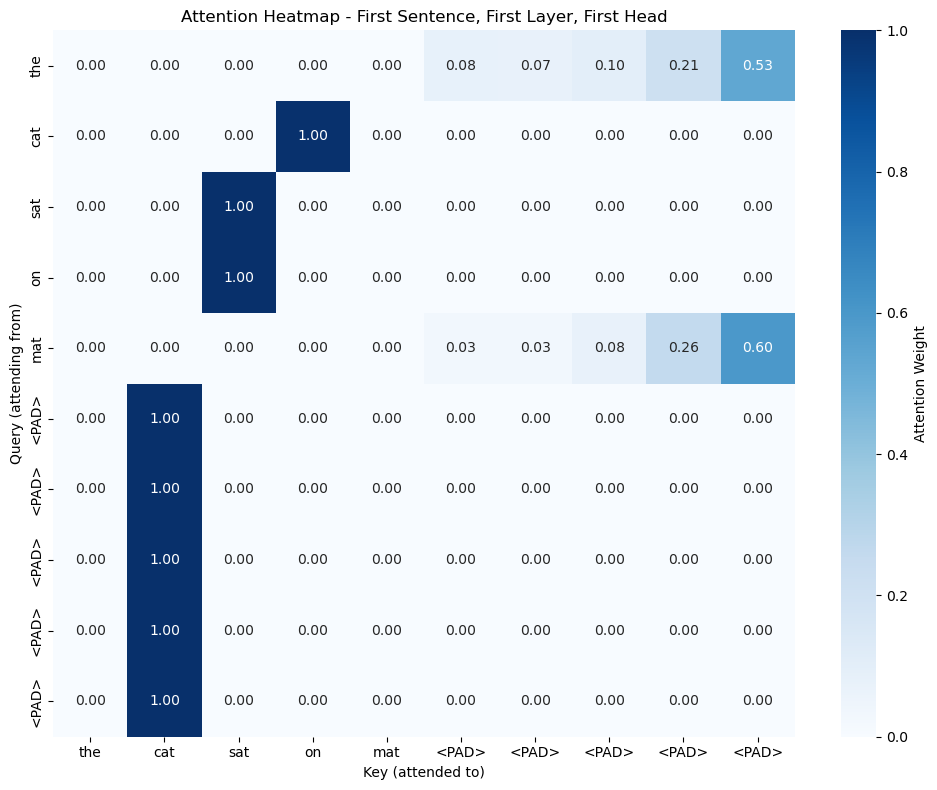


Attention weights matrix:
[[3.1432223e-09 1.1557499e-19 2.1853468e-13 1.2424023e-24 8.9459941e-17
  8.0482662e-02 7.4439548e-02 9.9461712e-02 2.1354531e-01 5.3207082e-01]
 [3.1312529e-19 7.0024268e-14 1.0147372e-10 9.9523312e-01 1.0626174e-08
  3.6801491e-04 7.6739304e-04 1.3002203e-03 1.3792296e-03 9.5203111e-04]
 [8.7468779e-31 1.1340528e-29 1.0000000e+00 7.0947436e-23 3.6018682e-29
  6.1407148e-23 4.2040897e-23 3.3150056e-23 3.4775040e-23 4.5688088e-23]
 [1.4662001e-10 2.7072282e-24 9.9887925e-01 5.6284221e-15 1.1489020e-09
  3.9057733e-05 4.3009462e-05 9.8915589e-05 3.0956659e-04 6.3012610e-04]
 [1.3648763e-17 3.1898441e-08 9.8448483e-30 2.4941749e-24 4.2582111e-20
  3.4361884e-02 3.3463623e-02 7.6097146e-02 2.5853136e-01 5.9754604e-01]
 [1.7488066e-16 9.9999702e-01 1.3792651e-12 4.9436409e-25 3.3660193e-11
  9.6983763e-07 5.4682806e-07 4.7021621e-07 5.1657332e-07 4.7235872e-07]
 [2.7469728e-16 9.9999440e-01 1.5509406e-12 8.7093656e-25 3.9955133e-11
  1.7896563e-06 1.0324126e-06 8

In [ ]:
# Visualize attention weights for first sentence, first layer, first head
first_sentence_tokens = [idx_to_word[idx.item()] if idx.item() < len(vocab)-1 else '<PAD>' 
                         for idx in tokenized_sentences[0]]

# Get attention weights from first layer, first head
attn_weights_first_layer = all_attn_weights[0]  # List of heads
attn_weights_first_head = attn_weights_first_layer[0]  # First head
attn_matrix = attn_weights_first_head[0].cpu().numpy()  # First sentence

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(attn_matrix, 
            xticklabels=first_sentence_tokens,
            yticklabels=first_sentence_tokens,
            annot=True, 
            fmt='.2f',
            cmap='Blues',
            cbar_kws={'label': 'Attention Weight'})
plt.title('Attention Heatmap - First Sentence, First Layer, First Head')
plt.xlabel('Key (attended to)')
plt.ylabel('Query (attending from)')
plt.tight_layout()
plt.show()

print("\nAttention weights matrix:")
print(attn_matrix)


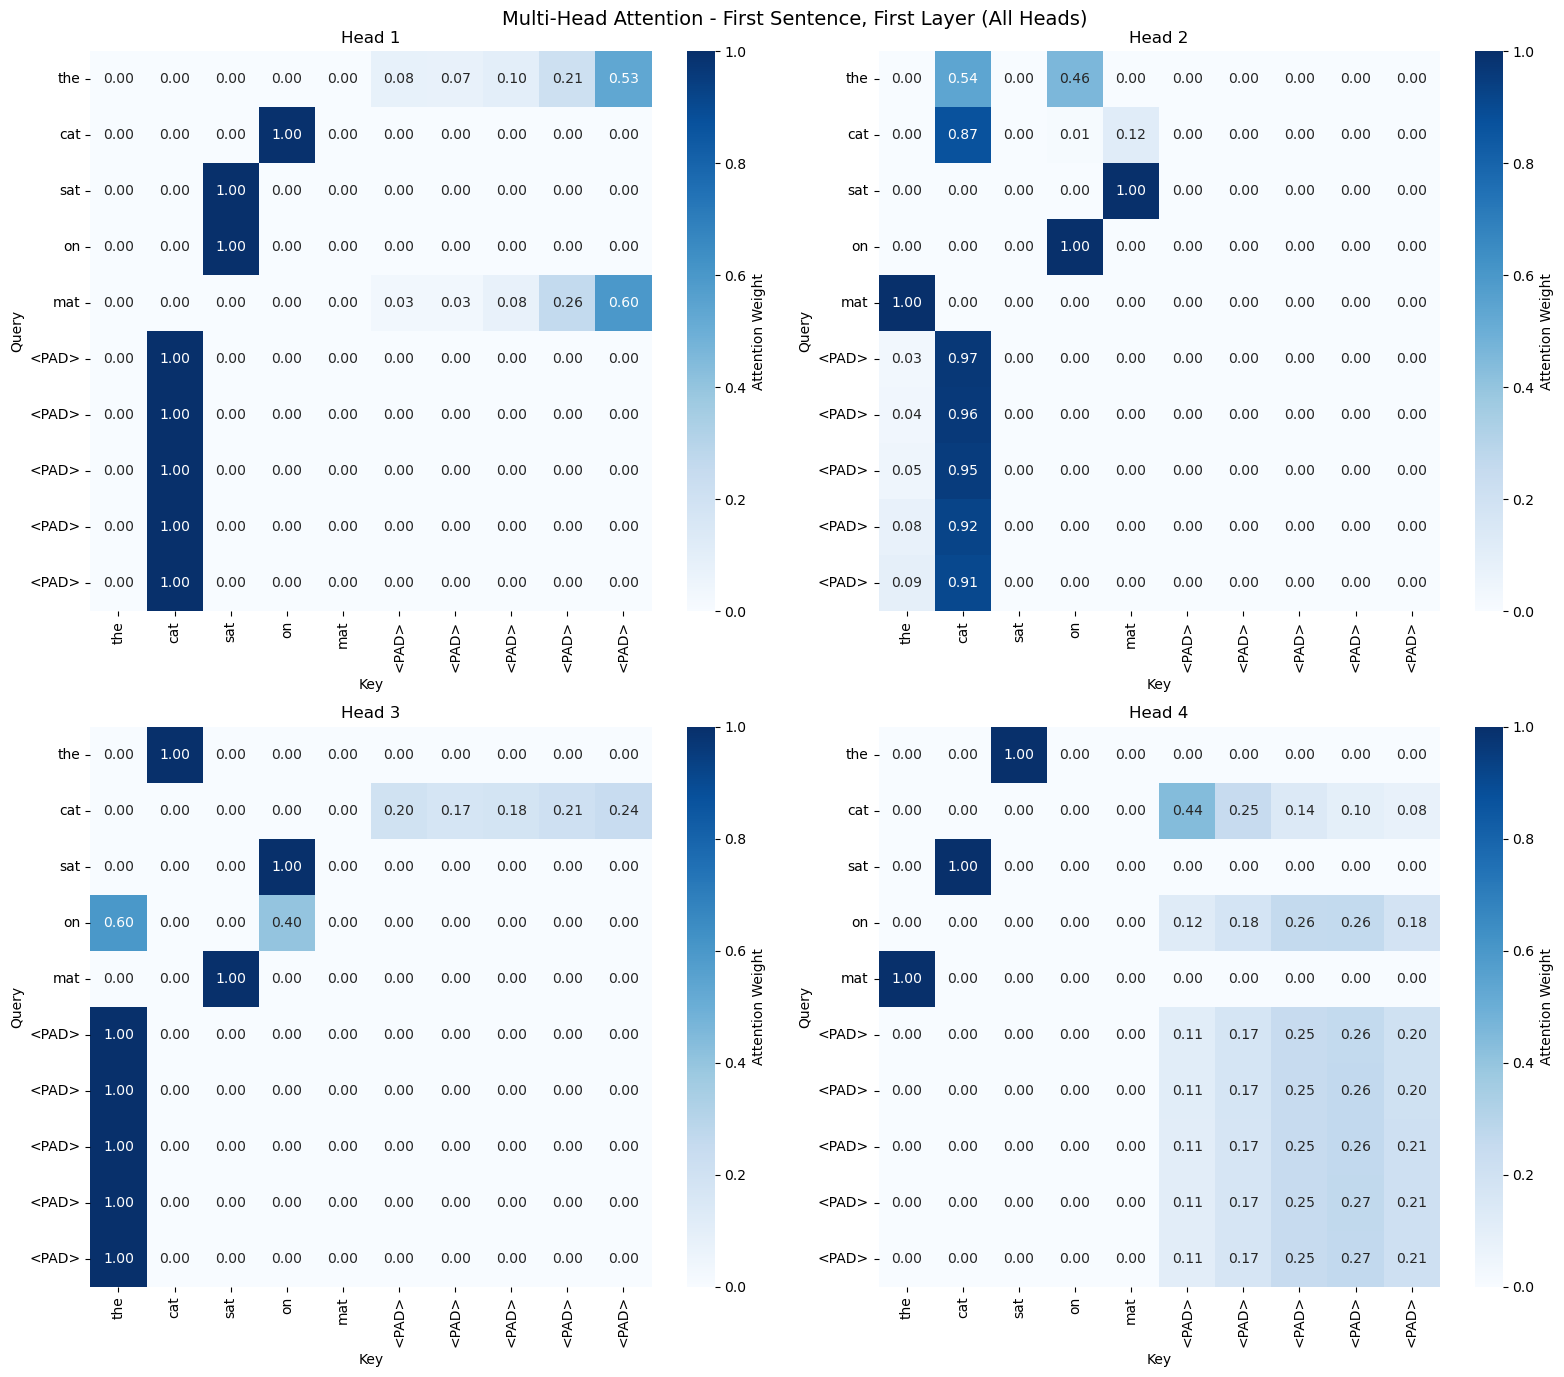

In [ ]:
# Show attention for all heads in first layer
fig, axes = plt.subplots(2, 2, figsize=(16, 14))
axes = axes.flatten()

for head_idx in range(num_heads):
    attn_matrix = all_attn_weights[0][head_idx][0].cpu().numpy()
    
    sns.heatmap(attn_matrix,
                xticklabels=first_sentence_tokens,
                yticklabels=first_sentence_tokens,
                annot=True,
                fmt='.2f',
                cmap='Blues',
                ax=axes[head_idx],
                cbar_kws={'label': 'Attention Weight'})
    axes[head_idx].set_title(f'Head {head_idx + 1}')
    axes[head_idx].set_xlabel('Key')
    axes[head_idx].set_ylabel('Query')

plt.suptitle('Multi-Head Attention - First Sentence, First Layer (All Heads)', fontsize=14)
plt.tight_layout()
plt.show()
